In [46]:
import nltk
import random
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, LSTM, SimpleRNN, GRU, Dense, Reshape
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from wordcloud import WordCloud
import numpy as np

# Download NLTK data (if not already downloaded)
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [17]:
# Load your dataset
# load dataset for train and test.
df_train = pd.read_csv("/content/drive/MyDrive/REX Technologies/Text Sentiment Analysis/train.csv",
                       encoding="latin-1")
df_test = pd.read_csv("/content/drive/MyDrive/REX Technologies/Text Sentiment Analysis/test.csv",
                      encoding="latin-1")
df = pd.concat([df_train,df_test],axis=0)
display(df.head())
display(df.tail())

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797.0,27400.0,105.0
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265.0,470.0,164.0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272.0,1246700.0,26.0


,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
4810,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4812,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
df = df.dropna()
df = df.drop_duplicates()
df[df.isnull()].count()

textID              0
text                0
selected_text       0
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

In [19]:
display(df.head())
display(df.tail())

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797.0,27400.0,105.0
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265.0,470.0,164.0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272.0,1246700.0,26.0


,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,night,31-45,Ghana,31072940.0,227540.0,137.0
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,morning,46-60,Greece,10423054.0,128900.0,81.0
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,noon,60-70,Grenada,112523.0,340.0,331.0
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,night,70-100,Guatemala,17915568.0,107160.0,167.0
27480,6f7127d9d7,All this flirting going on - The ATG smiles...,All this flirting going on - The ATG smiles. Y...,neutral,morning,0-20,Guinea,13132795.0,246000.0,53.0


In [29]:
# Define a function to preprocess the text
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    # Tokenize the text
    words = word_tokenize(text)
    # Remove stopwords and convert to lowercase
    filtered_words = [word.lower() for word in words if word.isalnum() and word.lower() not in stop_words]
    return " ".join(filtered_words)

# Preprocess the dataset
df["text"] = df["text"].apply(preprocess_text)


text = df['text'].tolist()
sentiment = df['sentiment'].tolist()
# y labal encodering
label_encoder = LabelEncoder()
y_label = label_encoder.fit_transform(sentiment)
df['polarity'] = y_label
display(df.head())
df['polarity'].unique()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),polarity
0,cb774db0d1,responded going,"I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0,1
1,549e992a42,sooo sad miss san diego,Sooo SAD,negative,noon,21-30,Albania,2877797.0,27400.0,105.0,0
2,088c60f138,boss bullying,bullying me,negative,night,31-45,Algeria,43851044.0,2381740.0,18.0,0
3,9642c003ef,interview leave alone,leave me alone,negative,morning,46-60,Andorra,77265.0,470.0,164.0,0
4,358bd9e861,sons put releases already bought,"Sons of ****,",negative,noon,60-70,Angola,32866272.0,1246700.0,26.0,0


array([1, 0, 2])

Data Exploration:
Number of rows: 27480
Columns: Index(['textID', 'text', 'selected_text', 'sentiment', 'Time of Tweet',
       'Age of User', 'Country', 'Population -2020', 'Land Area (Km²)',
       'Density (P/Km²)', 'polarity'],
      dtype='object')
       textID                              text  \
0  cb774db0d1                   responded going   
1  549e992a42           sooo sad miss san diego   
2  088c60f138                     boss bullying   
3  9642c003ef             interview leave alone   
4  358bd9e861  sons put releases already bought   

                         selected_text sentiment Time of Tweet Age of User  \
0  I`d have responded, if I were going   neutral       morning        0-20   
1                             Sooo SAD  negative          noon       21-30   
2                          bullying me  negative         night       31-45   
3                       leave me alone  negative       morning       46-60   
4                        Sons of ****,  negative 

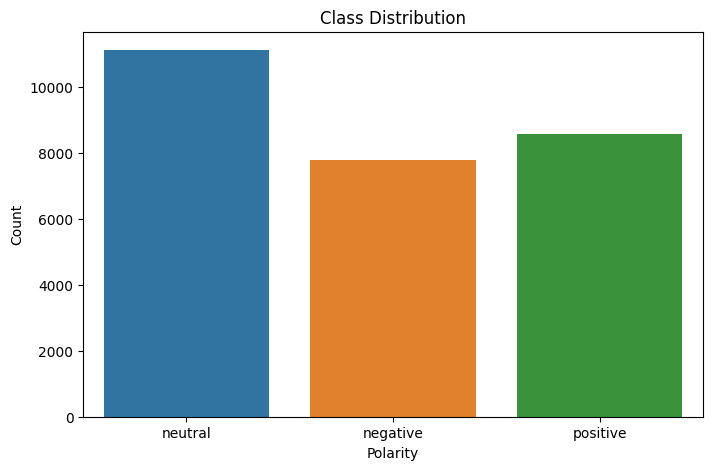

Class Distribution Details:
  sentiment  Count
0   neutral  11117
1  positive   8582
2  negative   7781


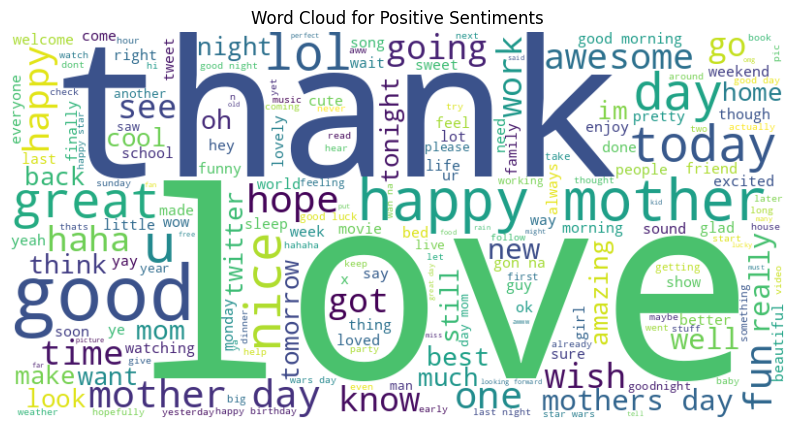

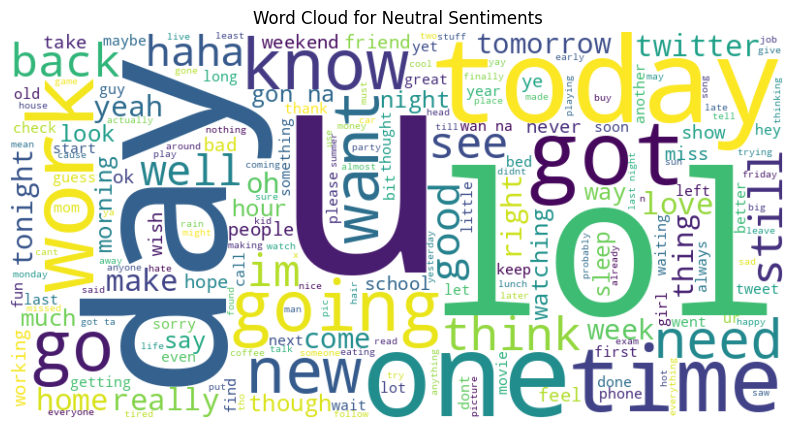

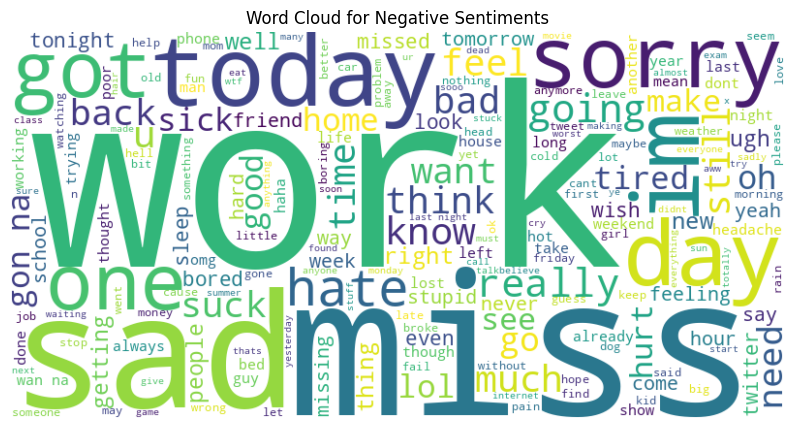

In [30]:
# Perform basic EDA
print("Data Exploration:")
print("Number of rows:", df.shape[0])
print("Columns:", df.columns)
print(df.head())

# Visualize class distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='sentiment')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

# Display class distribution details
class_counts = df['sentiment'].value_counts().reset_index()
class_counts.columns = ['sentiment', 'Count']
print("Class Distribution Details:")
print(class_counts)

# Generate word cloud for the 'text' column
positive_texts = " ".join(df[df['sentiment'] == "positive"]['text'])
neutral_texts = " ".join(df[df['sentiment'] == "neutral"]['text'])
negative_texts = " ".join(df[df['sentiment'] == "negative"]['text'])

plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_texts)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Positive Sentiments')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neutral_texts)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Neutral Sentiments')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 6))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_texts)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Negative Sentiments')
plt.axis('off')
plt.show()



In [36]:
max_words = 5000
max_len = 100

# Tokenize your text data
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(text)

# Convert text data to sequences
sequences = tokenizer.texts_to_sequences(text)

# Pad sequences to a fixed length
X = pad_sequences(sequences, maxlen=max_len)

# Define your labels (assuming you have 3 classes: positive, negative, neutral)
y = to_categorical(y_label, num_classes=3)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Training LSTM Model...
Epoch 1/3
550/550 [==============================] - 86s 103ms/step - loss: 0.8789 - accuracy: 0.5905 - val_loss: 0.7770 - val_accuracy: 0.6705
Epoch 2/3
550/550 [==============================] - 53s 97ms/step - loss: 0.6981 - accuracy: 0.7154 - val_loss: 0.7477 - val_accuracy: 0.6923
Epoch 3/3
172/172 [==============================] - 5s 25ms/step
LSTM Model - Loss: 0.7427306175231934 Accuracy: 0.6928675174713135
LSTM Model - Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.56      0.63      1572
           1       0.64      0.73      0.68      2236
           2       0.75      0.77      0.76      1688

    accuracy                           0.69      5496
   macro avg       0.71      0.69      0.69      5496
weighted avg       0.70      0.69      0.69      5496



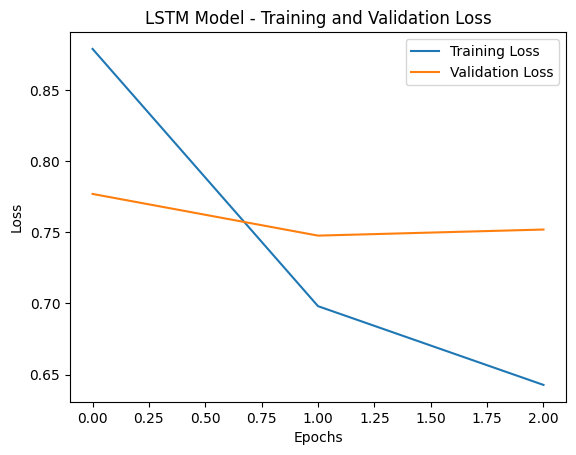

Training RNN Model...
Epoch 1/3
550/550 [==============================] - 28s 47ms/step - loss: 0.9238 - accuracy: 0.5551 - val_loss: 0.8061 - val_accuracy: 0.6618
Epoch 2/3
550/550 [==============================] - 25s 46ms/step - loss: 0.7080 - accuracy: 0.7110 - val_loss: 0.7797 - val_accuracy: 0.6771
Epoch 3/3
172/172 [==============================] - 2s 9ms/step
RNN Model - Loss: 0.8165292143821716 Accuracy: 0.6648471355438232
RNN Model - Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.58      0.62      1572
           1       0.64      0.65      0.64      2236
           2       0.70      0.76      0.73      1688

    accuracy                           0.66      5496
   macro avg       0.67      0.66      0.66      5496
weighted avg       0.66      0.66      0.66      5496



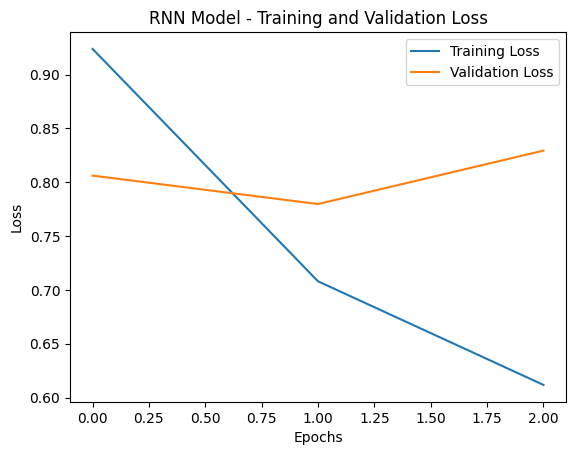

Training GRU Model...
Epoch 1/3
550/550 [==============================] - 63s 109ms/step - loss: 0.8671 - accuracy: 0.5983 - val_loss: 0.7805 - val_accuracy: 0.6793
Epoch 2/3
550/550 [==============================] - 53s 97ms/step - loss: 0.6968 - accuracy: 0.7164 - val_loss: 0.7600 - val_accuracy: 0.6946
Epoch 3/3
172/172 [==============================] - 5s 26ms/step
GRU Model - Loss: 0.7385817170143127 Accuracy: 0.6945050954818726
GRU Model - Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.58      0.64      1572
           1       0.63      0.76      0.69      2236
           2       0.80      0.71      0.75      1688

    accuracy                           0.69      5496
   macro avg       0.71      0.68      0.69      5496
weighted avg       0.70      0.69      0.69      5496



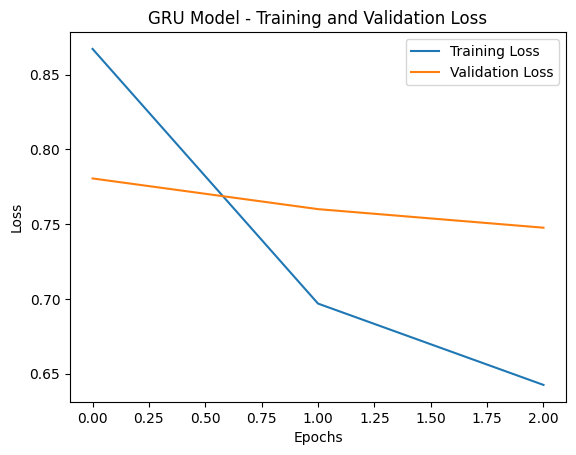

In [49]:
# Create models list
models = [
    ("LSTM", Sequential([
        Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
        LSTM(64),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])),
    ("RNN", Sequential([
        Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
        SimpleRNN(64),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])),
    ("GRU", Sequential([
        Embedding(input_dim=max_words, output_dim=64, input_length=max_len),
        GRU(64),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ]))
]

for model_name, model in models:
    print(f"Training {model_name} Model...")
    model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=3, validation_split=0.2, verbose=1)

    loss, accuracy = model.evaluate(X_test, y_test)
    predictions = model.predict(X_test)
    pred_labels = np.argmax(predictions, axis=1)

    print(f"{model_name} Model - Loss:", loss, "Accuracy:", accuracy)
    print(f"{model_name} Model - Classification Report:\n", classification_report(np.argmax(y_test, axis=1), pred_labels))

    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f"{model_name} Model - Training and Validation Loss")
    plt.show()

